In [6]:
import json
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.interpolate import PchipInterpolator
import numpy as np


In [7]:
def segment_key_to_float(k):
    return float(k.replace("_", "."))

def get_conf_dict(pred_segments, selected_audio):
    conf_dict = pred_segments[selected_audio]
    conf_dict = dict(sorted(conf_dict.items(), key=lambda x: segment_key_to_float(x[0])))    
    return conf_dict

In [24]:
duration = 60.0
selected_audio = '20190601_090000.WAV'
audio_path = f"/home/giacomoschiavo/Tovanella/{selected_audio}"

In [25]:
with open('/home/giacomoschiavo/finetuning-BirdNET/models/CustomCNN/best_model_config.json') as f:
    best_model_config = json.load(f)
best_model_config

{'file_name': 'model_ranking_config_9.json',
 'model_id': 1,
 'num_conv_layers': 3,
 'kernel_sizes': '[2, 4, 4]',
 'channels': '[16, 32, 64]',
 'batch_size': 32,
 'dropout': 0.5,
 'dense_hidden': 128,
 'micro_f1': 0.5288141688,
 'weighted_f1': 0.549890846,
 'samples_f1': 0.5180442375,
 'mean_f1': 0.5322497508}

In [26]:
# with open("/home/giacomoschiavo/finetuning-BirdNET/models/CustomCNN/config_9/1/test_pred_segments.json") as f:
#     pred_segments_cnn = json.load(f)

In [27]:
with open("/home/giacomoschiavo/finetuning-BirdNET/models/BirdNET_tuned/augm_final_1/test_pred_segments.json") as f:
    pred_segments_cnn = json.load(f)

In [28]:
def get_smoothed_curves(conf_dict, avg=True):
    time_points = np.arange(0, duration, 1.5)
    species_set = set()
    for seg in conf_dict.values():
        species_set.update(seg.keys())

    data = {s: [] for s in species_set}
    for t in time_points:
        t = str(t).replace(".", "_")  
        preds = conf_dict.get(t, {})
        for s in species_set:
            data[s].append(preds.get(s, 0.0))  # se manca, metti 0

    df = pd.DataFrame(data, index=time_points)
    if avg:
        df = df.rolling(window=3, min_periods=1, center=True).mean()
    return df


In [29]:
def plot_spectro_curves_overlay(pred_segments, selected_audio, avg=True):
    conf_dict = get_conf_dict(pred_segments, selected_audio)
    y, sr = librosa.load(audio_path, duration=duration)
    S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
    S_db = librosa.amplitude_to_db(np.abs(S), ref=np.max)

    fig, ax = plt.subplots(figsize=(18, 6))

    # Spettrogramma
    img = librosa.display.specshow(S_db, sr=sr, x_axis='time', y_axis='linear', cmap='gray_r', ax=ax)
    ax.set(title=f'Mel-Spectrogram with Confidence Curves {"(Smoothing average)" if avg else "without Smoothing"}')

    # Curve di confidenza (in overlay)
    df_smooth = get_smoothed_curves(conf_dict, avg)
    for specie in df_smooth.columns:
        if "_" not in specie:
            continue
        x = df_smooth.index.values.astype(float)
        y = df_smooth[specie].values
        interp = PchipInterpolator(x, y)
        xnew = np.linspace(x.min(), x.max(), 500)
        ynew = interp(xnew)

        # Mapping delle y da [0,1] a intervallo di frequenze visualizzate (es. 1000-2000 Hz)
        y_mapped = 0 + ynew * 2000  # supponiamo voglia mappare su 1000-2000 Hz

        ax.plot(xnew, y_mapped, label=specie, linewidth=2)

    ax.set_ylim(0, sr // 2)  # O limita solo a 1000-2000 se vuoi
    ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
    ax.grid(True)

    plt.tight_layout()
    plt.show()


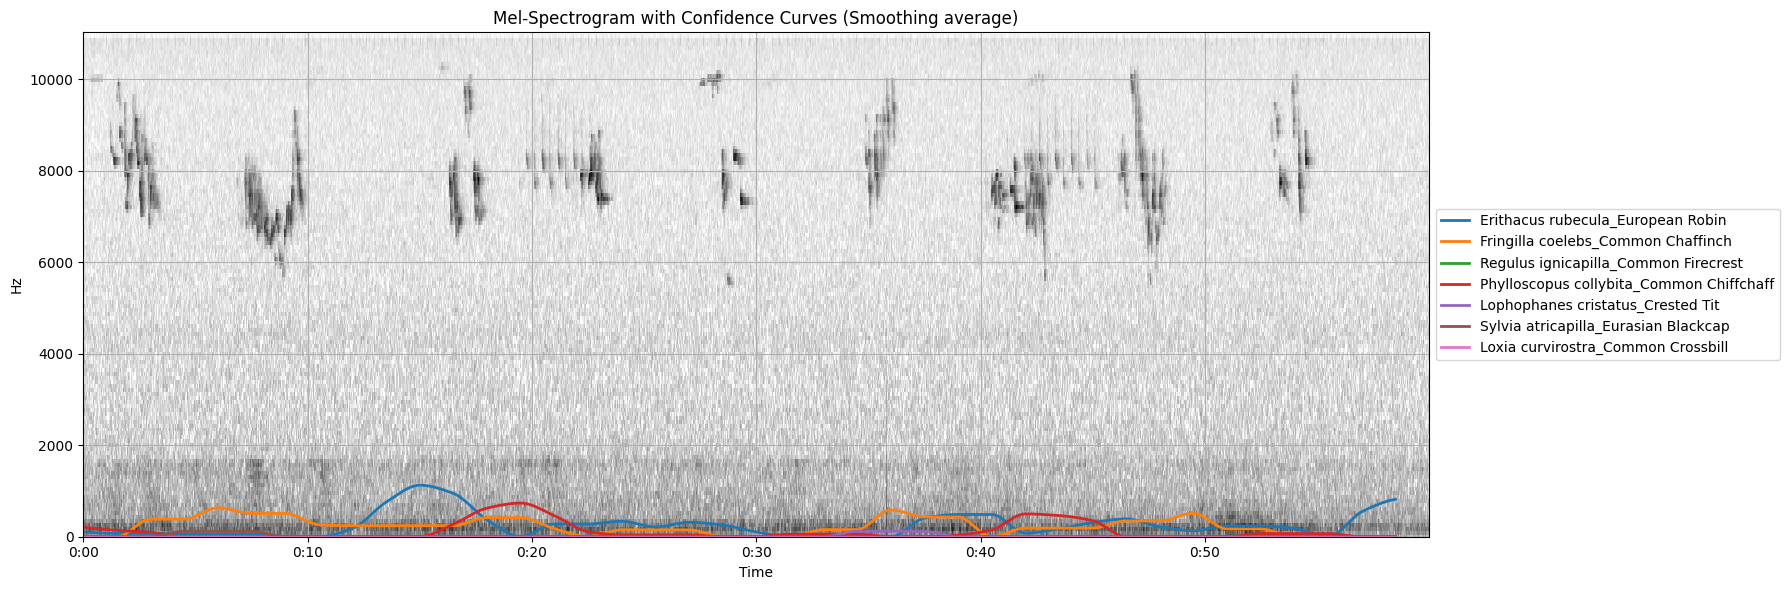

In [30]:
plot_spectro_curves_overlay(pred_segments_cnn, selected_audio, avg=True)

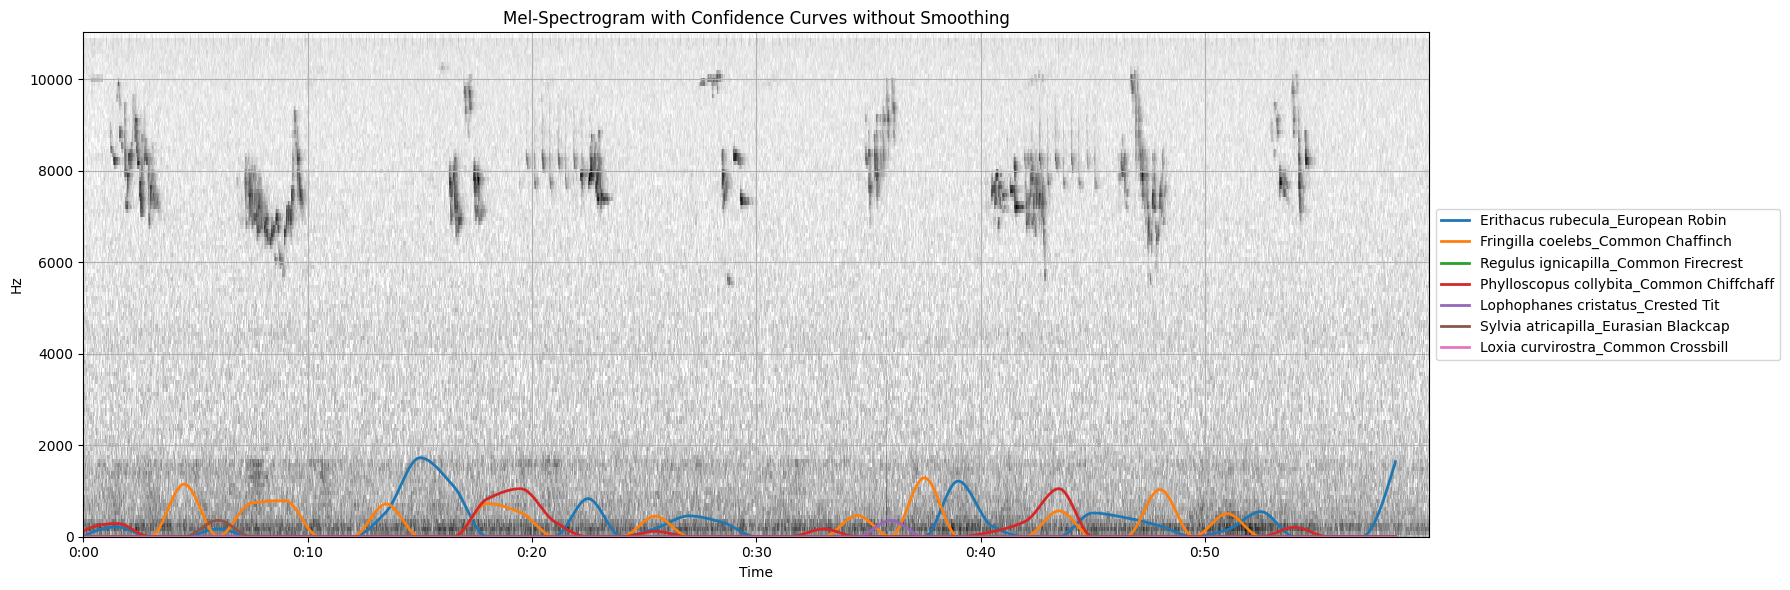

In [31]:
plot_spectro_curves_overlay(pred_segments_cnn, selected_audio, avg=False)